以下の理由から、非線形モデルとして"LightGBM"を使用

-> 高い精度を目指せる

-> 高速な訓練によりサイクル速く回せる

-> 時系列をカテゴリ変数として利用できる

-> 一部変数がやや裾が長いが、影響を受けにくい

In [2]:
#使用ライブラリを読み込み

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df = pd.read_csv("./use_data/ett.csv")

In [4]:
#時系列を変数として扱うために、年・月・日・時間のカラムをそれぞれ作成
#実用上、3年しかなく、将来予測には使えないため'年'は使用しない
date = df['date']

ymd_time = date.str.split() 
ymd = ymd_time.str[0]   #年月日
time = ymd_time.str[1]  #時間

ymd = ymd.str.split('-')
year = ymd.str[0]   #年
month = ymd.str[1]  #月
day = ymd.str[2]   #日

df['year'] = year
df['month'] = month
df['day'] = day
df['time'] = time

In [5]:
df

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,year,month,day,time
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,2016,07,01,00:00:00
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,2016,07,01,01:00:00
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,2016,07,01,02:00:00
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,2016,07,01,03:00:00
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,2016,07,01,04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000,2018,06,26,15:00:00
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000,2018,06,26,16:00:00
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000,2018,06,26,17:00:00
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000,2018,06,26,18:00:00


In [6]:
# 時系列をラベルエンコーディング

label_encoders = {}

# 質的変数にラベルエンコーディングを適用
for column in ['month', 'day', 'time']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le  

データの分割は、

訓練データ -> 2018-01-31まで (データの8割)

テストデータ -> 2018-02-01以降 (データの2割)

で行う。検証データは訓練データの2割

In [8]:
# データの分割

explain_vars = [ 'date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'month', 'day', 'time']
X = df[explain_vars].set_index('date')
y = df[['date','OT']].set_index('date')

# 訓練データとテストデータに分割
X_train = X[:'2018-01-31 23:00:00']
y_train = y [:'2018-01-31 23:00:00']
X_test = X['2018-02-01 00:00:00':]   #テストデータを作成
y_test = y['2018-02-01 00:00:00':]

# 訓練データと検証データを分割（手動で時系列順に分割）
train_size = int(len(X_train) * 0.8)  # 訓練データの80%を使用
X_val = X_train.iloc[train_size:]
y_val = y_train.iloc[train_size:]
X_train = X_train.iloc[:train_size]
y_train = y_train.iloc[:train_size]



In [9]:
y_val = y_val.squeeze()
y_test = y_test.squeeze()

In [10]:
# 時系列分割
tscv = TimeSeriesSplit(n_splits=3)  # 分割数に3を指定

In [11]:
# LightGBMを構築.パラメータはGridSearchで探索
lgbm = LGBMRegressor(random_state=42)

# ハイパーパラメータの設定範囲
param_grid = {
    'num_leaves': np.arange(77,82,1),
    'learning_rate': np.arange(0.14,0.16,0.002),
    'n_estimators': np.arange(175,190,5),
    'max_depth': np.arange(8,14,2),
}




# GridSearchCVの設定
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # 評価指標：MSE (負の値で返される)
    cv=tscv,  
    verbose=0,
    n_jobs=-1   # 並列実行の指定（全プロセス使用）
)

# グリッドサーチの実行
grid_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1314
[LightGBM] [Info] Number of data points in the train set: 11136, number of used features: 9
[LightGBM] [Info] Start training from score 17.003074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': array([0.14 , 0.142, 0.144, 0.146, 0.148, 0.15 , 0.152, 0.154, 0.156,
       0.158]),
                         'max_depth': array([ 8, 10, 12]),
                         'n_estimators': array([175, 180, 185]),
                         'num_leaves': array([77, 78, 79, 80, 81])},
             scoring='neg_mean_squared_error')

In [12]:
# 最適なモデルで検証データを評価
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)

# 結果出力
print("Best Parameters:", grid_search.best_params_)
print(f"Validation RMSE: {rmse:.4f}")

Best Parameters: {'learning_rate': 0.14400000000000002, 'max_depth': 12, 'n_estimators': 175, 'num_leaves': 79}
Validation RMSE: 7.3496


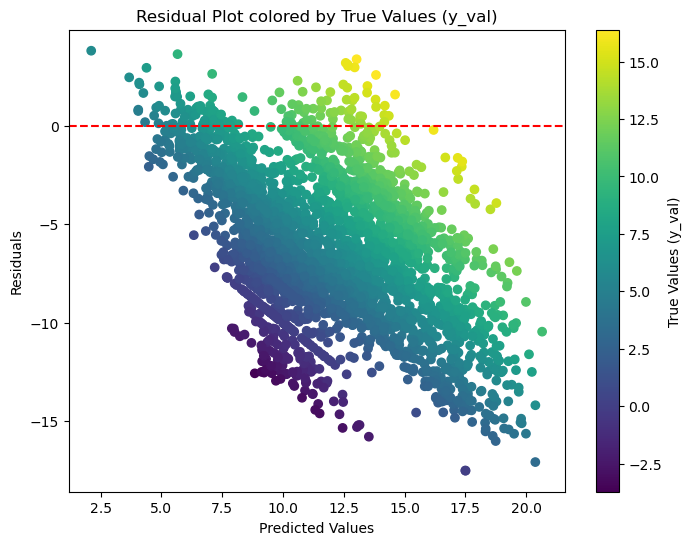

In [13]:
# 残差プロット

residuals = y_val-y_pred 

# カラーマップを使用して、yの値に基づいて色分けしたプロットを作成
plt.figure(figsize=(8, 6))
sc = plt.scatter(y_pred, residuals, c=y_val, cmap=cm.viridis)  # y_testに基づいて色分け

cbar = plt.colorbar(sc)  # カラーバーを追加
cbar.set_label('True Values (y_val)')  # カラーバーにラベルを追加

plt.axhline(y=0, color='r', linestyle='--')  # 残差が0のライン
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot colored by True Values (y_val)")
plt.show()


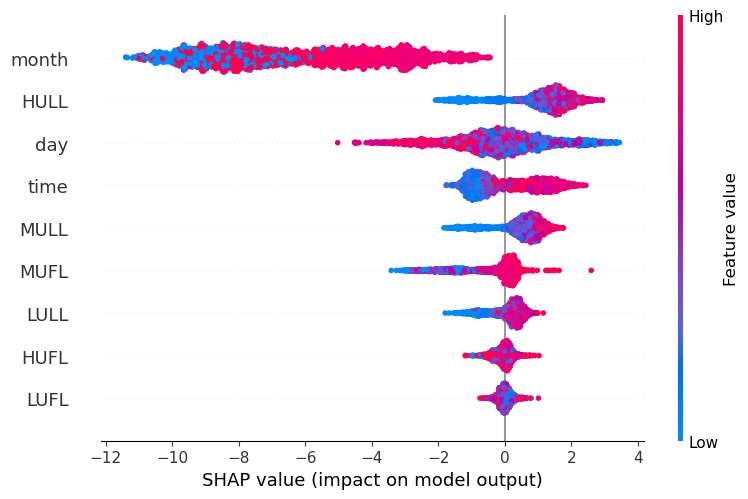

In [14]:
# SHAP値を観察
explainer = shap.Explainer(best_model)

# SHAP値の計算（検証データに対して計算）
shap_values = explainer(X_val)

shap.summary_plot(shap_values, X_val)

In [15]:
# 最適なモデルでテストデータを評価
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred,)

# 結果出力
print("Best Parameters:", grid_search.best_params_)
print(f"Test RMSE: {rmse:.4f}")

Best Parameters: {'learning_rate': 0.14400000000000002, 'max_depth': 12, 'n_estimators': 175, 'num_leaves': 79}
Test RMSE: 7.3617


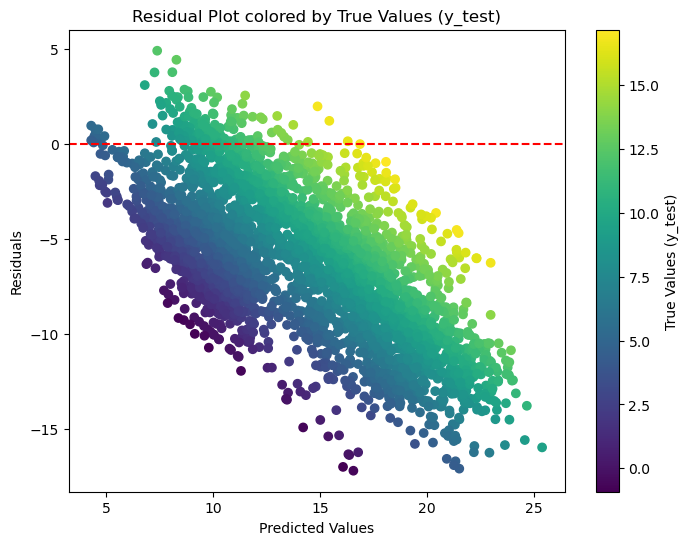

In [16]:
# 残差プロット

residuals = y_test-y_pred 

# カラーマップを使用して、yの値に基づいて色分けしたプロットを作成
plt.figure(figsize=(8, 6))
sc = plt.scatter(y_pred, residuals, c=y_test, cmap=cm.viridis)  # y_testに基づいて色分け

cbar = plt.colorbar(sc)  # カラーバーを追加
cbar.set_label('True Values (y_test)')  # カラーバーにラベルを追加

plt.axhline(y=0, color='r', linestyle='--')  # 残差が0のライン
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot colored by True Values (y_test)")
plt.show()


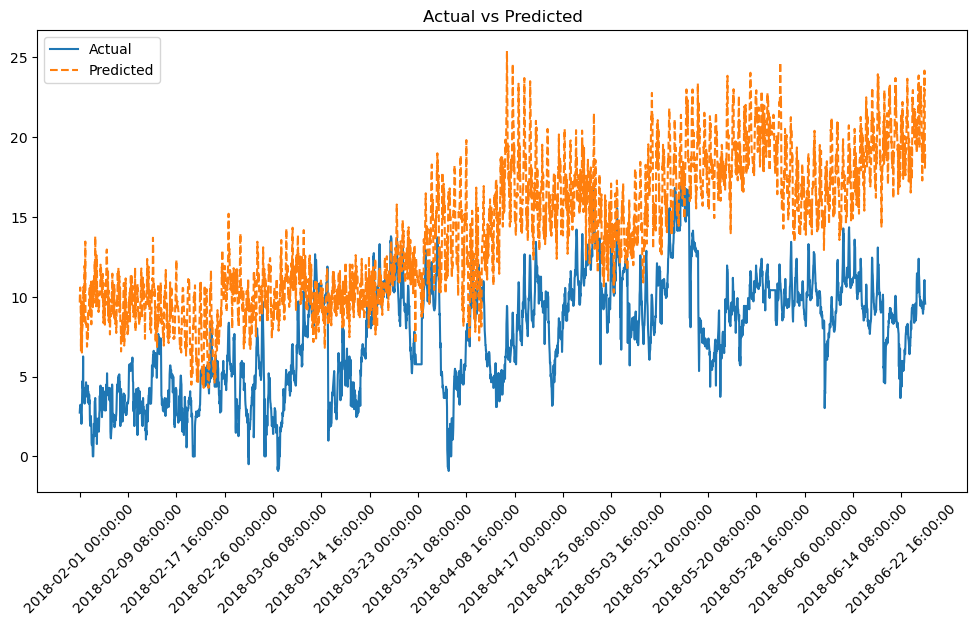

In [17]:
# 予測値と実測値をプロット

plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Actual')
plt.plot(X_test.index, y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.xticks(y_test.index[::200], rotation=45)  # インデックスを間引き
plt.title('Actual vs Predicted')
plt.show()

訓練データにおいて、2016年を抜いてみる

In [225]:
# データの分割

explain_vars = [ 'date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'month', 'day', 'time']
X = df[explain_vars].set_index('date')
y = df[['date','OT']].set_index('date')

# 訓練データとテストデータに分割
X_train = X['2017-01-01 00:00:00':'2018-01-31 23:00:00']
y_train = y ['2017-01-01 00:00:00':'2018-01-31 23:00:00']
X_test = X['2018-02-01 00:00:00':]   #テストデータを作成
y_test = y['2018-02-01 00:00:00':]

# 訓練データと検証データを分割（手動で時系列順に分割）
train_size = int(len(X_train) * 0.8)  # 訓練データの80%を使用
X_val = X_train.iloc[train_size:]
y_val = y_train.iloc[train_size:]
X_train = X_train.iloc[:train_size]
y_train = y_train.iloc[:train_size]



In [227]:
y_val = y_val.squeeze()
y_test = y_test.squeeze()

In [229]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

7603
1901
3500


In [231]:
# LightGBMを構築.パラメータはGridSearchで探索
lgbm = LGBMRegressor(random_state=42)

# ハイパーパラメータの設定範囲
param_grid = {
    'num_leaves': np.arange(77,82,1),
    'learning_rate': np.arange(0.14,0.16,0.002),
    'n_estimators': np.arange(175,190,5),
    'max_depth': np.arange(8,14,2),
}




# GridSearchCVの設定
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # 評価指標：MSE (負の値で返される)
    cv=tscv,  
    verbose=0,
    n_jobs=-1   # 並列実行の指定（全プロセス使用）
)

# グリッドサーチの実行
grid_search.fit(X_train, y_train)

C:\Users\AVRJ0006\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 7603, number of used features: 9
[LightGBM] [Info] Start training from score 13.554960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': array([0.14 , 0.142, 0.144, 0.146, 0.148, 0.15 , 0.152, 0.154, 0.156,
       0.158]),
                         'max_depth': array([ 8, 10, 12]),
                         'n_estimators': array([175, 180, 185]),
                         'num_leaves': array([77, 78, 79, 80, 81])},
             scoring='neg_mean_squared_error')

In [232]:
# 最適なモデルで検証データを評価
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)

# 結果出力
print("Best Parameters:", grid_search.best_params_)
print(f"Validation RMSE: {rmse:.4f}")

Best Parameters: {'learning_rate': 0.14600000000000002, 'max_depth': 10, 'n_estimators': 175, 'num_leaves': 79}
Validation RMSE: 5.8704


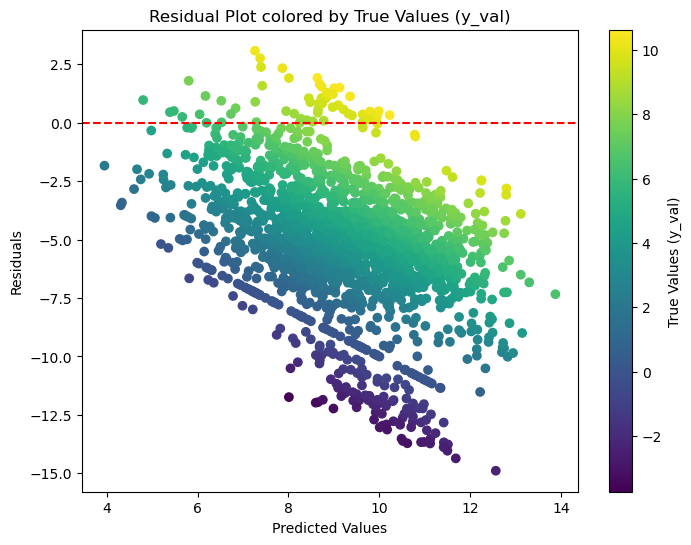

In [233]:
# 残差プロット

y_pred_series = pd.Series(y_pred, index=y_val.index)
residuals = y_val-y_pred 

# カラーマップを使用して、yの値に基づいて色分けしたプロットを作成
plt.figure(figsize=(8, 6))
sc = plt.scatter(y_pred, residuals, c=y_val, cmap=cm.viridis)  # y_testに基づいて色分け

cbar = plt.colorbar(sc)  # カラーバーを追加
cbar.set_label('True Values (y_val)')  # カラーバーにラベルを追加

plt.axhline(y=0, color='r', linestyle='--')  # 残差が0のライン
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot colored by True Values (y_val)")
plt.show()


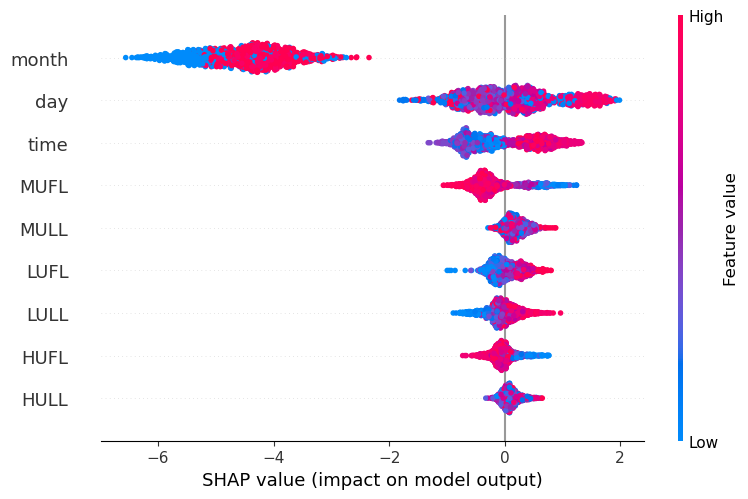

In [234]:
# SHAP値を観察
explainer = shap.Explainer(best_model)

# SHAP値の計算（検証データに対して計算）
shap_values = explainer(X_val)

shap.summary_plot(shap_values, X_val)

In [235]:
# 最適なモデルでテストデータを評価
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred,)

# 結果出力
print("Best Parameters:", grid_search.best_params_)
print(f"Test RMSE: {rmse:.4f}")

Best Parameters: {'learning_rate': 0.14600000000000002, 'max_depth': 10, 'n_estimators': 175, 'num_leaves': 79}
Test RMSE: 7.0676


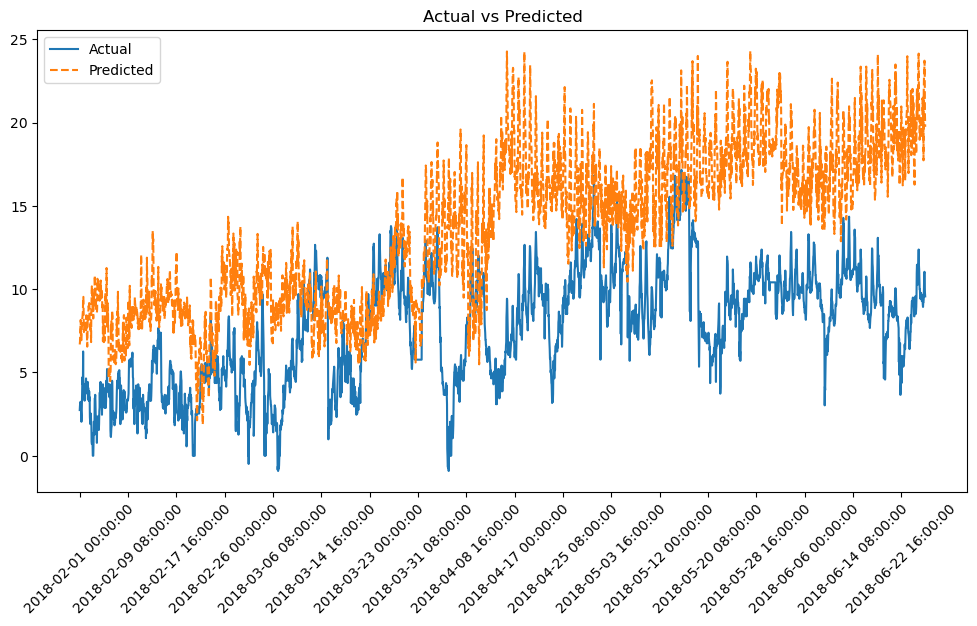

In [236]:
# 予測値と実測値をプロット

plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Actual')
plt.plot(X_test.index, y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.xticks(y_test.index[::200], rotation=45)  # インデックスを間引き
plt.title('Actual vs Predicted')
plt.show()

In [27]:
for lag in range(1, 8):  # 1日〜7日分のラグ
    df[f'lag_{lag}'] = df['OT'].shift(lag)
    
# 移動平均
df['rolling_mean_3'] = df['OT'].shift(1).rolling(window=3).mean()  # 3日間の移動平均
df = df.fillna(-9999)

In [28]:
df

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,year,month,day,time,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean_3
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,2016,6,0,0,-9999.000000,-9999.000000,-9999.000000,-9999.000,-9999.000,-9999.000,-9999.000,-9999.000000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,2016,6,0,1,30.531000,-9999.000000,-9999.000000,-9999.000,-9999.000,-9999.000,-9999.000,-9999.000000
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,2016,6,0,2,27.787001,30.531000,-9999.000000,-9999.000,-9999.000,-9999.000,-9999.000,-9999.000000
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,2016,6,0,3,27.787001,27.787001,30.531000,-9999.000,-9999.000,-9999.000,-9999.000,28.701667
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,2016,6,0,4,25.044001,27.787001,27.787001,30.531,-9999.000,-9999.000,-9999.000,26.872667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000,2018,5,25,15,10.200000,9.426000,9.215000,9.215,8.934,9.075,9.426,9.613667
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000,2018,5,25,16,10.904000,10.200000,9.426000,9.215,9.215,8.934,9.075,10.176667
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000,2018,5,25,17,11.044000,10.904000,10.200000,9.426,9.215,9.215,8.934,10.716000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000,2018,5,25,18,10.271000,11.044000,10.904000,10.200,9.426,9.215,9.215,10.739667


In [29]:
# 時系列をラベルエンコーディング

label_encoders = {}

# 質的変数にラベルエンコーディングを適用
for column in ['month', 'day', 'time']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le  

In [30]:
# データの分割

explain_vars = [ 'date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'month', 'day', 'time']
X = df.drop(columns=['OT','year']).set_index('date')
y = df[['date','OT']].set_index('date')

# 訓練データとテストデータに分割
X_train = X['2017-01-01 00:00:00':'2018-01-31 23:00:00']
y_train = y ['2017-01-01 00:00:00':'2018-01-31 23:00:00']
X_test = X['2018-02-01 00:00:00':]   #テストデータを作成
y_test = y['2018-02-01 00:00:00':]

# 訓練データと検証データを分割（手動で時系列順に分割）
train_size = int(len(X_train) * 0.8)  # 訓練データの80%を使用
X_val = X_train.iloc[train_size:]
y_val = y_train.iloc[train_size:]
X_train = X_train.iloc[:train_size]
y_train = y_train.iloc[:train_size]


In [31]:
y_val = y_val.squeeze()
y_test = y_test.squeeze()

In [179]:
# LightGBMを構築.パラメータはGridSearchで探索

lgbm = LGBMRegressor(random_state=42)

# ハイパーパラメータの設定範囲
param_grid = {
    'num_leaves': np.arange(10,20,5),
    'learning_rate': np.arange(0.02,0.08,0.02),
    'n_estimators': np.arange(165,185,5),
    'max_depth': np.arange(5,20,5),
    'lambda1': np.arange(0.05,0.1,0.05),
    'lambda2': np.arange(0.05,0.1,0.05),
    
}


# GridSearchCVの設定
lgb_grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # 評価指標：MSE (負の値で返される)
    cv=tscv,  
    verbose=0,
    n_jobs=-1   # 並列実行の指定（全プロセス使用）
)

# グリッドサーチの実行
lgb_grid_search.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: lambda1
[LightGBM] [Warning] Unknown parameter: lambda2
[LightGBM] [Warning] Unknown parameter: lambda1
[LightGBM] [Warning] Unknown parameter: lambda2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3319
[LightGBM] [Info] Number of data points in the train set: 7603, number of used features: 17
[LightGBM] [Info] Start training from score 13.554960


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'lambda1': array([0.05]), 'lambda2': array([0.05]),
                         'learning_rate': array([0.02, 0.04, 0.06]),
                         'max_depth': array([ 5, 10, 15]),
                         'n_estimators': array([165, 170, 175, 180]),
                         'num_leaves': array([10, 15])},
             scoring='neg_mean_squared_error')

In [180]:
# 最適なモデルで検証データを評価
lgb_best_model = lgb_grid_search.best_estimator_
lgb_y_pred = lgb_best_model.predict(X_val)
rmse = root_mean_squared_error(y_val, lgb_y_pred)

# 結果出力
print("Best Parameters:", lgb_grid_search.best_params_)
print(f"Validation RMSE: {rmse:.4f}")

[LightGBM] [Warning] Unknown parameter: lambda1
[LightGBM] [Warning] Unknown parameter: lambda2
Best Parameters: {'lambda1': 0.05, 'lambda2': 0.05, 'learning_rate': 0.06, 'max_depth': 10, 'n_estimators': 165, 'num_leaves': 10}
Validation RMSE: 1.1700


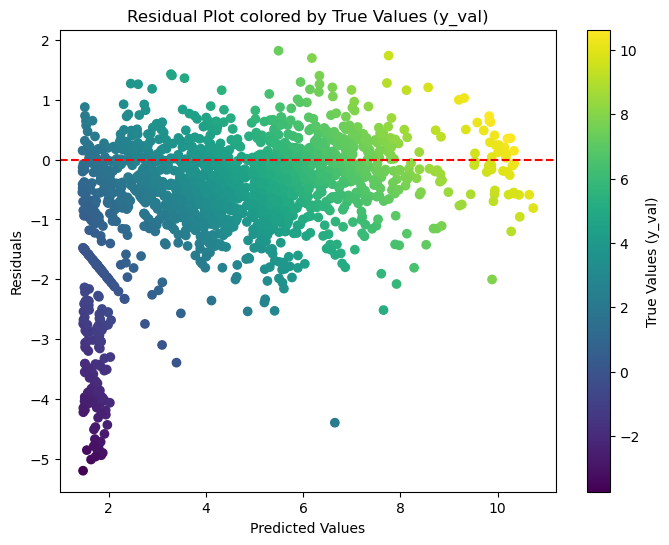

In [181]:
# 残差プロット

lgb_y_pred_series = pd.Series(lgb_y_pred, index=y_val.index)
residuals = y_val-lgb_y_pred 

# カラーマップを使用して、yの値に基づいて色分けしたプロットを作成
plt.figure(figsize=(8, 6))
sc = plt.scatter(lgb_y_pred, residuals, c=y_val, cmap=cm.viridis)  # y_testに基づいて色分け

cbar = plt.colorbar(sc)  # カラーバーを追加
cbar.set_label('True Values (y_val)')  # カラーバーにラベルを追加

plt.axhline(y=0, color='r', linestyle='--')  # 残差が0のライン
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot colored by True Values (y_val)")
plt.show()

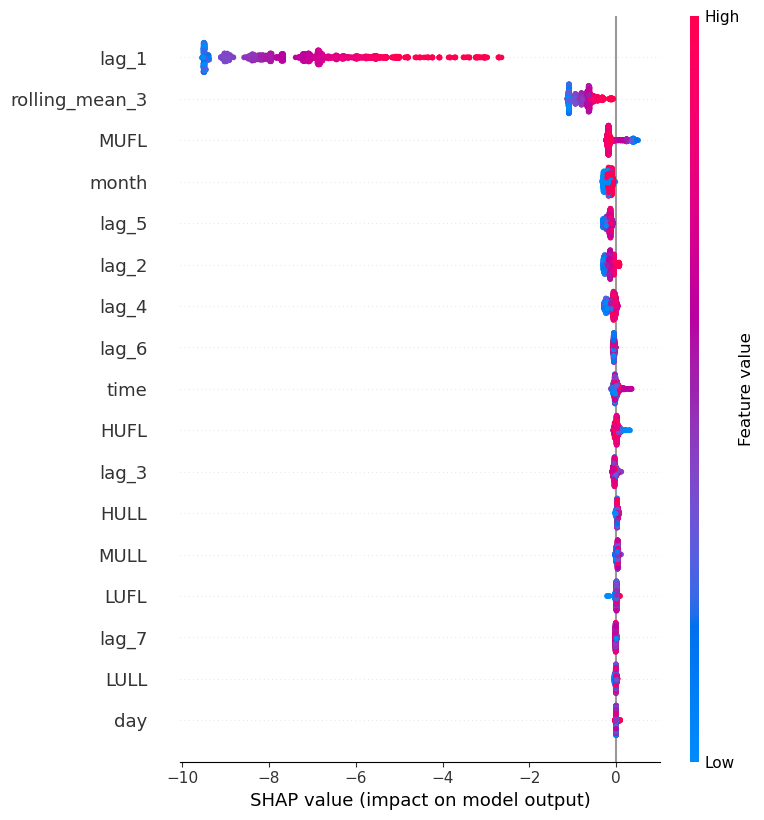

In [185]:
# SHAP値を観察
explainer = shap.Explainer(lgb_best_model)

# SHAP値の計算（検証データに対して計算）
shap_values = explainer(X_val)

shap.summary_plot(shap_values, X_val)

In [189]:
# 最適なモデルでテストデータを評価
lgb_best_model = lgb_grid_search.best_estimator_
lgb_y_pred = lgb_best_model.predict(X_test)
rmse = root_mean_squared_error(y_test, lgb_y_pred,)

# 結果出力
print("Best Parameters:", grid_search.best_params_)
print(f"Test RMSE: {rmse:.4f}")

[LightGBM] [Warning] Unknown parameter: lambda1
[LightGBM] [Warning] Unknown parameter: lambda2
Best Parameters: {'learning_rate': 0.14600000000000002, 'max_depth': 10, 'n_estimators': 175, 'num_leaves': 79}
Test RMSE: 0.7643


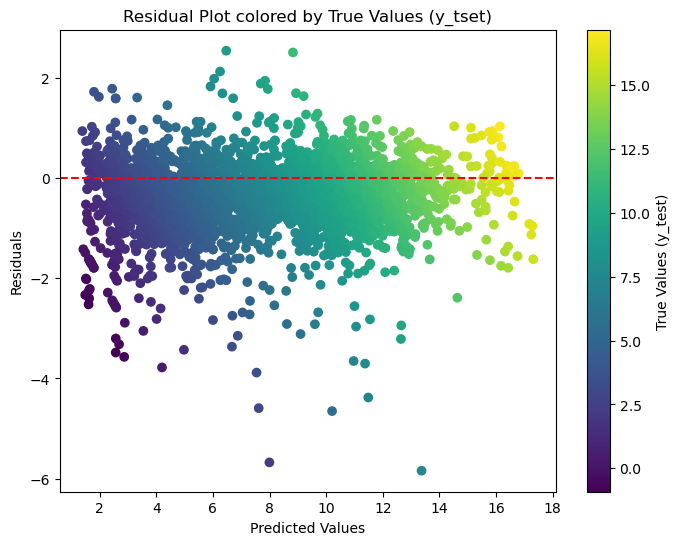

In [191]:
# 残差プロット

lgb_y_pred_series = pd.Series(lgb_y_pred, index=y_test.index)
residuals = y_test-lgb_y_pred 

# カラーマップを使用して、yの値に基づいて色分けしたプロットを作成
plt.figure(figsize=(8, 6))
sc = plt.scatter(lgb_y_pred, residuals, c=y_test, cmap=cm.viridis)  # y_testに基づいて色分け

cbar = plt.colorbar(sc)  # カラーバーを追加
cbar.set_label('True Values (y_test)')  # カラーバーにラベルを追加

plt.axhline(y=0, color='r', linestyle='--')  # 残差が0のライン
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot colored by True Values (y_tset)")
plt.show()

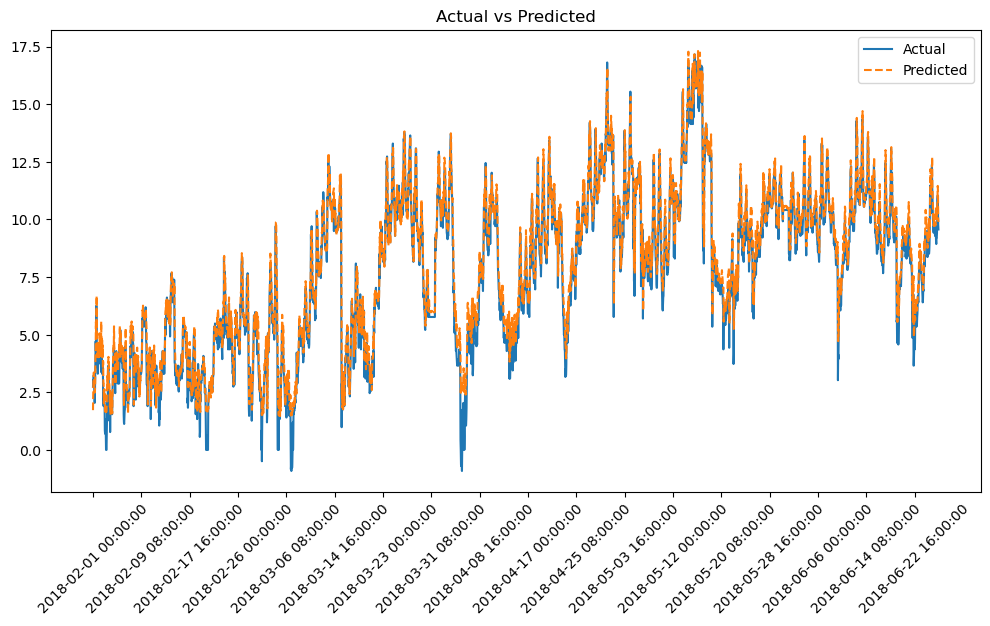

In [193]:
# 予測値と実測値をプロット

plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Actual')
plt.plot(X_test.index, lgb_y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.xticks(y_test.index[::200], rotation=45)  # インデックスを間引き
plt.title('Actual vs Predicted')
plt.show()

仮説メモ:やや過大評価気味である

過少評価気味のSARIMAXモデルとのアンサンブルによるさらなる改善を目指す

In [198]:
# 仮説を立てたパラメータでSARIMAXモデルを作る（周期を3で指定してやってみる）

sarimax_model = SARIMAX(y_train,
                exog=X_train,
                order=[2, 0, 1],
                seasonal_order=[2, 1, 1, 3],    #周期を3で指定
                enforce_stationarity=False,
                enforce_invertibility=False)

# モデルを適合
sarimax_model_fit = sarimax_model.fit(disp=False)

# 結果の表示
print(sarimax_model_fit.summary())

C:\Users\AVRJ0006\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\AVRJ0006\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\AVRJ0006\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                                OT   No. Observations:                 7603
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 3)   Log Likelihood              -10161.268
Date:                           Sat, 30 Nov 2024   AIC                          20370.535
Time:                                   11:38:58   BIC                          20536.971
Sample:                               01-01-2017   HQIC                         20427.653
                                    - 11-13-2017                                         
Covariance Type:                             opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
HUFL              -0.0327      0.021     -1.569      0.117      -0.074       0.008
HULL               0.0049      

In [199]:
# LightGBMのテストデータ予測
y_val_pred_lgb = lgb_best_model.predict(X_val)


# SARIMAXのテストデータ予測
sarimax_result = sarimax_model.fit(disp=False)
y_val_pred_sarimax = sarimax_result.predict(
    start=len(X_train),
    end=len(X_train) + len(X_val) - 1,
    exog=X_val)

[LightGBM] [Warning] Unknown parameter: lambda1
[LightGBM] [Warning] Unknown parameter: lambda2


C:\Users\AVRJ0006\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [200]:
# LightGBMがやや過大評価気味であるため割り振る比の和を"0.95"にする。それぞれに割り当てる比は、検証データのRMSEができるだけ低くなる点で選定
# また、LightGBMにはやや偏りがあったため、汎化性能向上のためにSARIMAXモデルの比を0.01以上とする

y_val_pred_ensemble = 0.94 * y_val_pred_lgb + 0.01 * y_val_pred_sarimax

In [202]:
rmse = mean_squared_error(y_val, y_val_pred_ensemble, squared=False)
print(f"RMSE of Ensemble Model: {rmse}")

RMSE of Ensemble Model: 1.1498021733821113


C:\Users\AVRJ0006\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [207]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


X_train shape: (7603, 17)
X_val shape: (1901, 17)
X_test shape: (3500, 17)


In [209]:
# LightGBMのテストデータ予測
y_test_pred_lgb = lgb_best_model.predict(X_test)


# SARIMAXのテストデータ予測
sarimax_result = sarimax_model.fit(disp=False)
y_test_pred_sarimax = sarimax_result.predict(
    start=len(X_train),
    end=len(X_train) + len(X_val) + len(X_test) - 1,
    exog=pd.concat([X_val,X_test],axis=0)
)
y_test_pred_sarimax =  y_test_pred_sarimax[1901:]  #X_testの部分のみ抜き取る





[LightGBM] [Warning] Unknown parameter: lambda1
[LightGBM] [Warning] Unknown parameter: lambda2


C:\Users\AVRJ0006\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [215]:
y_test_pred_ensemble = 0.95 * y_test_pred_lgb + 0.0 * y_test_pred_sarimax

In [217]:
rmse = mean_squared_error(y_test, y_test_pred_ensemble, squared=False)
print(f"RMSE of Ensemble Model: {rmse}")

RMSE of Ensemble Model: 0.6977947701709866


C:\Users\AVRJ0006\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


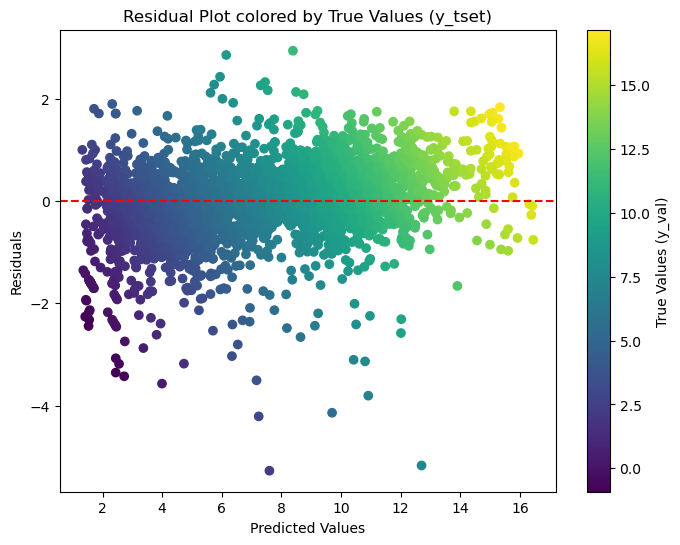

In [219]:
# 残差プロット

y_pred_series = pd.Series(y_test_pred_ensemble, index=y_val.index)
residuals = y_test.reset_index(drop=True) - y_test_pred_ensemble.reset_index(drop=True) 

# カラーマップを使用して、yの値に基づいて色分けしたプロットを作成
plt.figure(figsize=(8, 6))
sc = plt.scatter(y_test_pred_ensemble, residuals, c=y_test, cmap=cm.viridis)  # y_testに基づいて色分け

cbar = plt.colorbar(sc)  # カラーバーを追加
cbar.set_label('True Values (y_val)')  # カラーバーにラベルを追加

plt.axhline(y=0, color='r', linestyle='--')  # 残差が0のライン
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot colored by True Values (y_tset)")
plt.show()

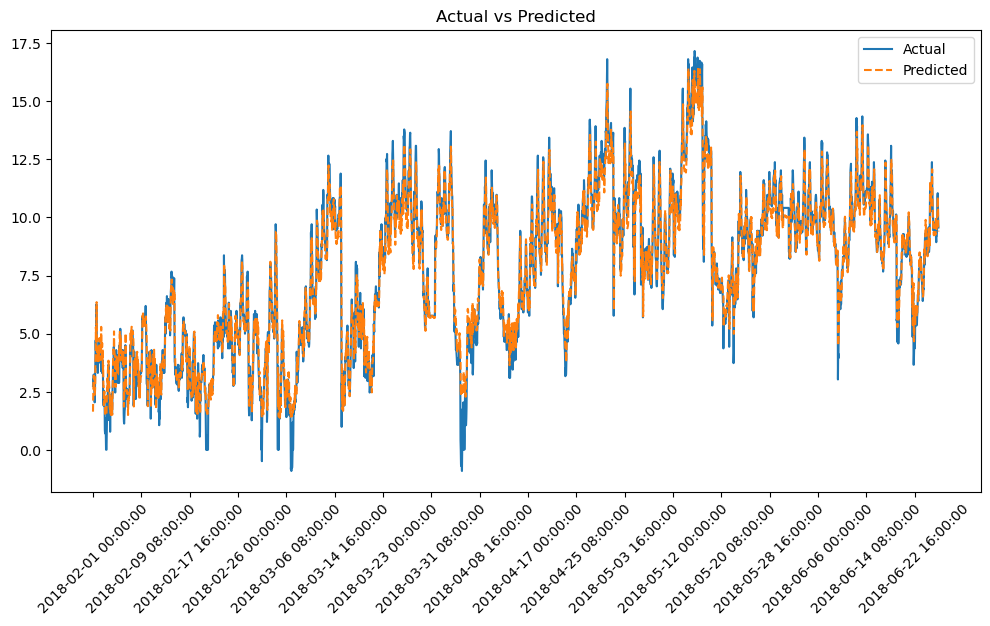

In [221]:
# 予測値と実測値をプロット

plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Actual')
plt.plot(X_test.index, y_test_pred_ensemble, label='Predicted', linestyle='--')
plt.legend()
plt.xticks(y_test.index[::200], rotation=45)  # インデックスを間引き
plt.title('Actual vs Predicted')
plt.show()

ある程度動きをとらえられているものの、まだ先端をとり逃している -> さらに複雑なモデル(DL等)を用いる